<h1><b> Loan Status Forecast

 <b> 1. Import Library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


<b> 2. Data Cleaning

In [2]:
df = pd.read_csv('loan-train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


remove loan id column (unused)

In [3]:
df.drop(["Loan_ID"], axis="columns", inplace=True)
df.dropna(inplace=True)

edit and convert number on string data to numeric

In [4]:
df.Dependents = df['Dependents'].replace('3+', '3')
df.Dependents = pd.to_numeric(df['Dependents'], errors='coerce').astype(int)

df.Dependents.unique()

df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


convert y/n and male/female data to 1/0

In [5]:
df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0})
df['Married'] = df['Married'].replace({'Yes': 1, 'No': 0})
df['Self_Employed'] = df['Self_Employed'].replace({'Yes': 1, 'No': 0})
df['Property_Area'] = pd.factorize(df['Property_Area'])[0] + 1
df['Loan_Status'] = df['Loan_Status'].replace({'Y': 1, 'N': 0})
df['Education'] = df['Education'].replace({'Graduate': 1, "Not Graduate": 0})
df["Credit_History"] = pd.to_numeric(df['Credit_History'], errors='coerce').astype(int)
df["LoanAmount"] = pd.to_numeric(df['LoanAmount'], errors='coerce').astype(int)

base on dataset source, loan amount are written in hundred so we will use the real number

In [6]:
df["LoanAmount"] = df.LoanAmount*1000

look at features correlation and remove unperformed features

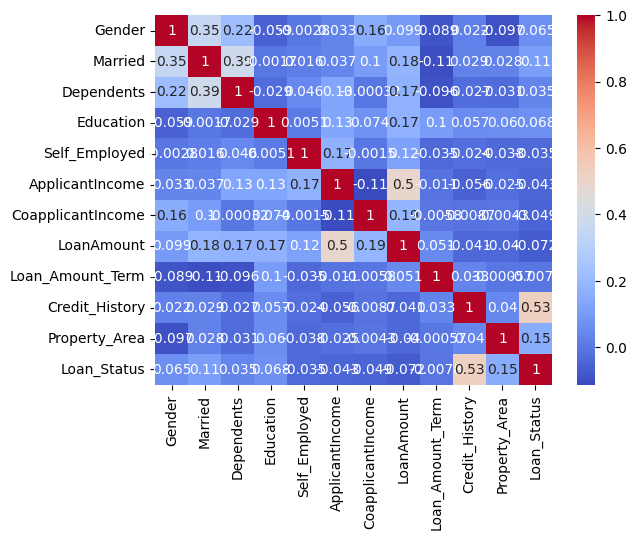

In [7]:
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)

plt.show()

In [8]:
df.drop(["CoapplicantIncome", "Loan_Amount_Term", "Self_Employed"], axis="columns", inplace=True)

scalling amount loan and applicant income data

In [9]:
scaler = StandardScaler()
df[["ApplicantIncome", "LoanAmount"]] = scaler.fit_transform(df[["ApplicantIncome", "LoanAmount"]])

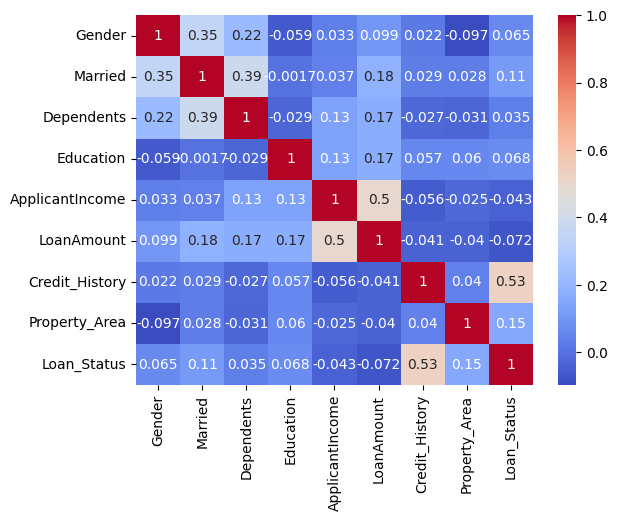

In [10]:
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)

plt.show()

each column impact on loan status visualization

<Axes: xlabel='Property_Area'>

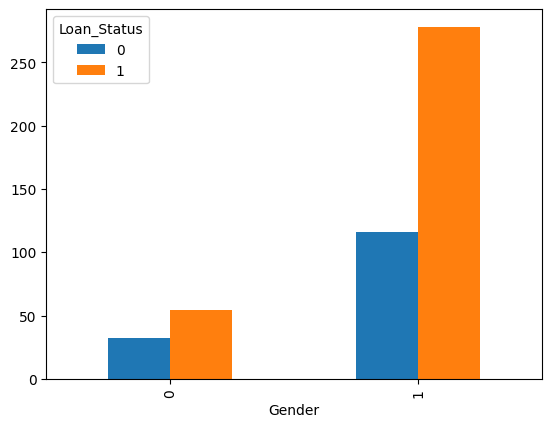

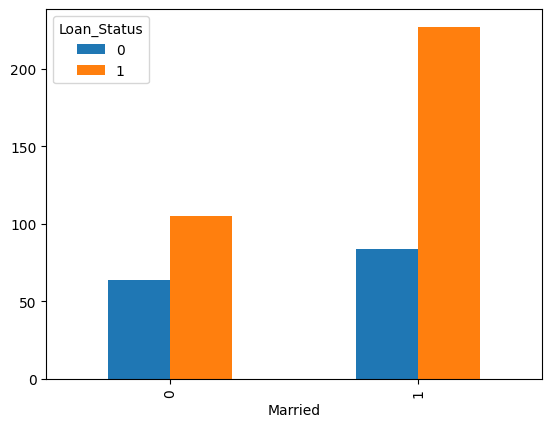

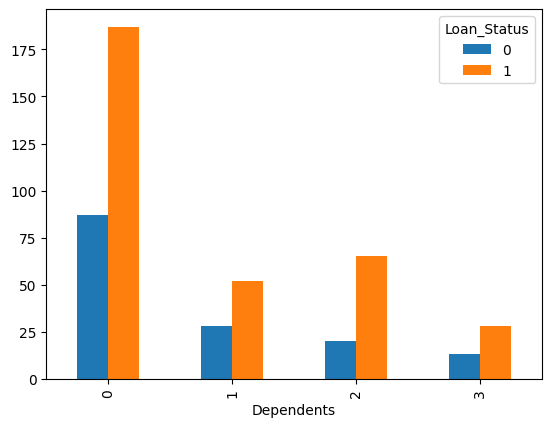

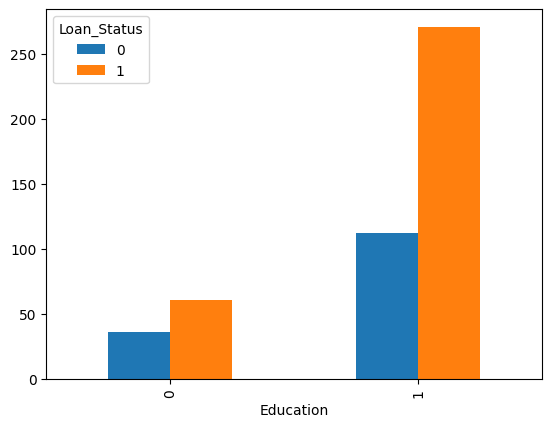

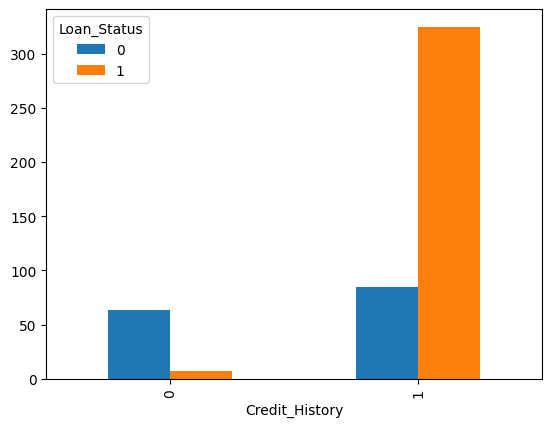

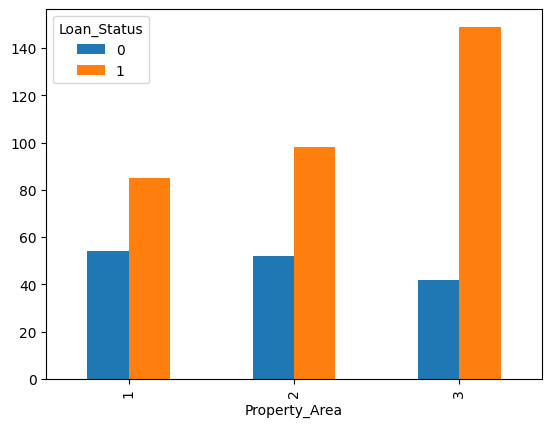

In [11]:
pd.crosstab(df['Gender'], df.Loan_Status).plot(kind="bar")
pd.crosstab(df['Married'], df.Loan_Status).plot(kind="bar")
pd.crosstab(df['Dependents'], df.Loan_Status).plot(kind="bar")
pd.crosstab(df['Education'], df.Loan_Status).plot(kind="bar")
pd.crosstab(df['Credit_History'], df.Loan_Status).plot(kind="bar")
pd.crosstab(df['Property_Area'], df.Loan_Status).plot(kind="bar")

<b> 3. Imbalance handling

In [12]:
df[df.Loan_Status == 1].shape

(332, 9)

In [13]:
df[df.Loan_Status == 0].shape

(148, 9)

In [14]:
X = df.drop(["Loan_Status"], axis=1)
y = df['Loan_Status']

smote = SMOTE(random_state=42)

Xr, yr = smote.fit_resample(X, y)

<Axes: xlabel='Property_Area'>

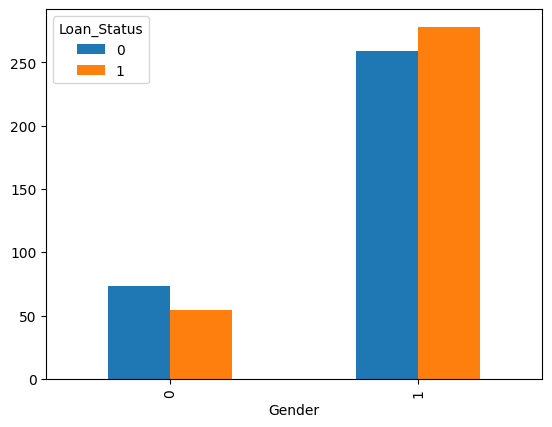

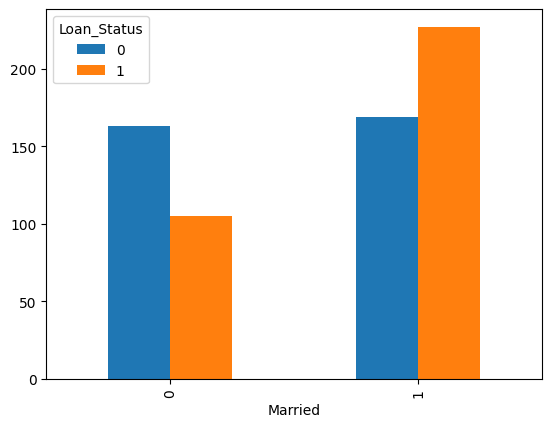

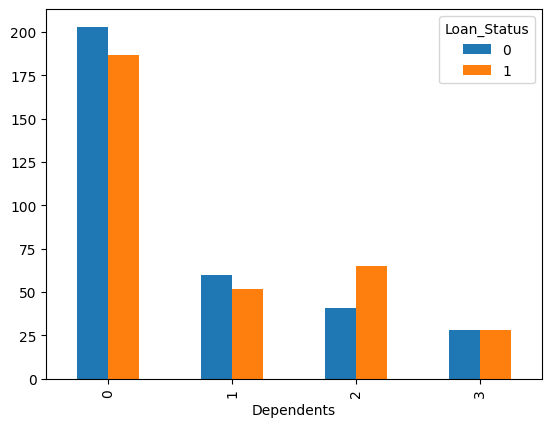

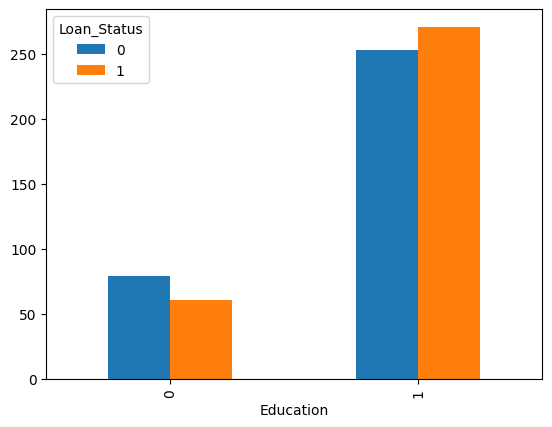

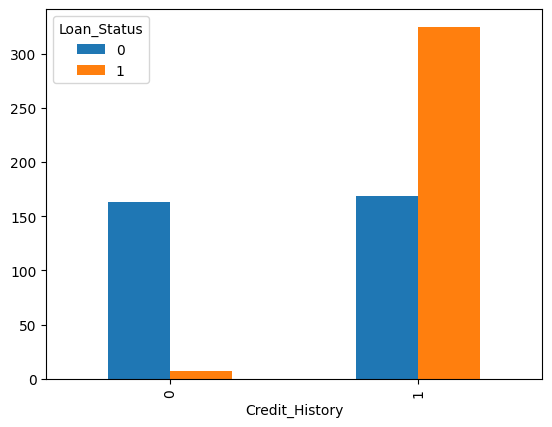

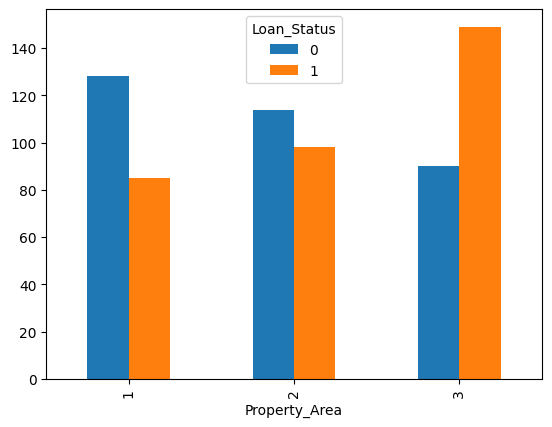

In [15]:
pd.crosstab(Xr['Gender'], yr).plot(kind="bar")
pd.crosstab(Xr['Married'], yr).plot(kind="bar")
pd.crosstab(Xr['Dependents'], yr).plot(kind="bar")
pd.crosstab(Xr['Education'], yr).plot(kind="bar")
pd.crosstab(Xr['Credit_History'], yr).plot(kind="bar")
pd.crosstab(Xr['Property_Area'], yr).plot(kind="bar")

<b> 4. Data Preparation

In [16]:
Xr.head()

,Gender,Married,Dependents,Education,ApplicantIncome,LoanAmount,Credit_History,Property_Area
0,1,1,1,1,-0.137970,-0.208089,1,1
1,1,1,0,1,-0.417536,-0.979001,1,2
2,1,1,0,0,-0.491180,-0.307562,1,2
3,1,0,0,1,0.112280,-0.046446,1,2
4,1,1,2,1,0.009319,1.520245,1,2


In [17]:
X_train, X_test, y_train, y_test = train_test_split(Xr, yr, test_size=0.3, random_state=64)

<b> 5. Create Logistic Regression model

In [18]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear']
}

lr = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best parameters:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score:  0.8120376382876383


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

In [19]:
regression = LogisticRegression(C=1, penalty='l1', solver='liblinear')
regression.fit(X_train, y_train)
regression.score(X_test, y_test)

0.78

In [20]:
print(classification_report(y_test, regression.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73        91
           1       0.75      0.89      0.82       109

    accuracy                           0.78       200
   macro avg       0.79      0.77      0.77       200
weighted avg       0.79      0.78      0.78       200



In [28]:
X_train



,Gender,Married,Dependents,Education,ApplicantIncome,LoanAmount,Credit_History,Property_Area
339,1,1,0,1,-0.519084,-0.021578,1,3
532,1,1,0,0,-0.550717,0.516763,0,2
124,1,1,0,1,0.453658,1.619718,1,2
226,0,0,0,1,-0.488178,-0.568677,1,3
340,1,0,0,1,-0.285082,-0.556243,1,2
...,...,...,...,...,...,...,...,...
85,1,1,3,0,-0.581602,-0.630847,1,3
54,1,1,3,0,0.306546,-0.245391,1,2
166,1,1,1,1,0.427874,1.184525,1,2
119,1,0,0,1,-0.372678,-1.177946,1,2


<b> 6. pickling logistic model

In [29]:
y_train

339    1
532    0
124    0
226    0
340    1
      ..
85     1
54     1
166    1
119    1
452    1
Name: Loan_Status, Length: 464, dtype: int64

In [21]:
with open('logistic.pkl', 'wb') as f:
    pickle.dump(regression, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [26]:
Xnew = [[1,1,0,1,-0.519084,-0.021578,1,3]]

ynew = regression.predict(Xnew)

print(ynew)

[1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
